In [2]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [3]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [4]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.046 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

### Parsing

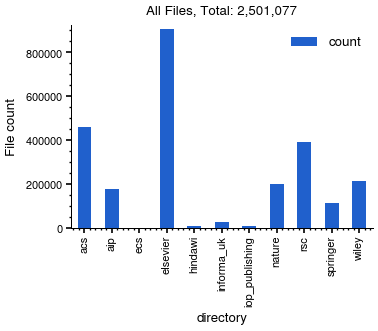

,directory,count
0,acs,457468
1,aip,177932
2,ecs,42
3,elsevier,907234
4,hindawi,6951
5,informa_uk,27900
6,iop_publishing,8007
7,nature,198487
8,rsc,392347
9,springer,111360


In [6]:
df = execute("""
             SELECT directory, count(*) FROM paper_corpus pc
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='File count', title=f"All Files, Total: {total:,}")
plt.savefig('notebooks/files_per_directory.png', dpi=600)
plt.show()
df

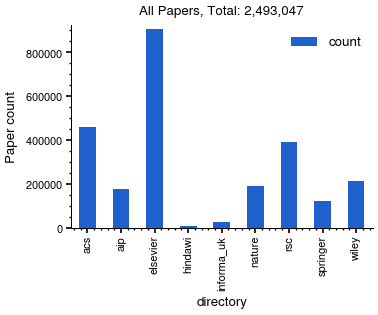

,directory,count
0,acs,457510
1,aip,177932
2,elsevier,907234
3,hindawi,6951
4,informa_uk,27898
5,nature,189039
6,rsc,392346
7,springer,120808
8,wiley,213329


In [7]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"All Papers, Total: {total:,}")
plt.savefig('notebooks/papers_per_directory.png', dpi=600)
plt.show()
df

In [12]:
print("Papers in database, not in corpus:")
df = execute("""
    SELECT p.directory, count(*) FROM papers p
    WHERE NOT EXISTS (
        SELECT 1 FROM paper_corpus pc 
        WHERE pc.doi = p.doi
    )
    GROUP BY p.directory;
""")
print(df['count'].sum())
df

Papers in database, not in corpus:
89386


,directory,count
0,acs,22211
1,elsevier,8200
2,informa_uk,2
3,rsc,37292
4,springer,17088
5,wiley,4593


In [11]:
print("Papers in corpus, not in database:")
df = execute("""
    SELECT pc.directory, count(*) FROM paper_corpus pc 
    WHERE NOT EXISTS (
        SELECT 1 FROM papers p 
        WHERE p.doi = pc.doi
    )
    GROUP BY pc.directory;
""")
print(df['count'].sum())
df

Papers in corpus, not in database:
97416


,directory,count
0,acs,22169
1,ecs,42
2,elsevier,8200
3,informa_uk,4
4,iop_publishing,8007
5,nature,9448
6,rsc,37293
7,springer,7640
8,wiley,4613


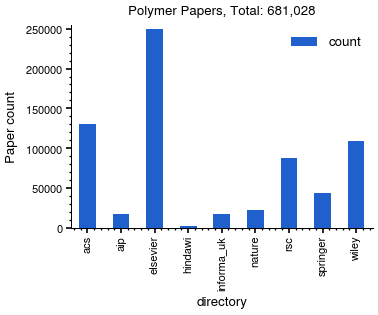

,directory,count
0,acs,130971
1,aip,17070
2,elsevier,250057
3,hindawi,2605
4,informa_uk,17396
5,nature,22208
6,rsc,87429
7,springer,44324
8,wiley,108968


In [13]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             JOIN filtered_papers fp on fp.doi = p.doi
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"Polymer Papers, Total: {total:,}")
plt.savefig('notebooks/polymer_papers_per_directory.png', dpi=600)
plt.show()
df

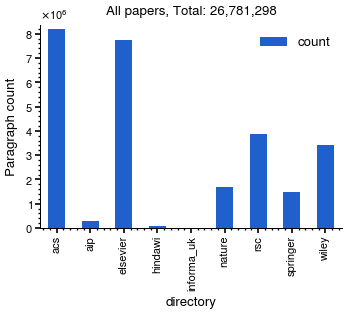

,directory,count
0,acs,8208346
1,aip,272475
2,elsevier,7727368
3,hindawi,83812
4,informa_uk,24
5,nature,1698156
6,rsc,3884198
7,springer,1478719
8,wiley,3428200


In [14]:
df = execute("""
        SELECT directory, count(*) FROM paper_texts pt
        GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title=f"All papers, Total: {total:,}")
plt.savefig('notebooks/paragraphs_per_directory.png', dpi=600)
plt.show()
df

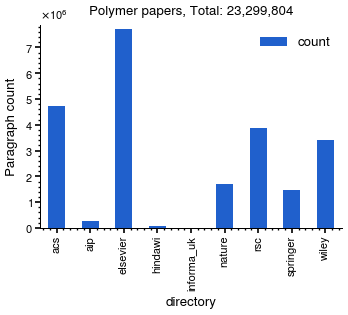

,directory,count
0,acs,4726853
1,aip,272475
2,elsevier,7727367
3,hindawi,83812
4,informa_uk,24
5,nature,1698156
6,rsc,3884198
7,springer,1478719
8,wiley,3428200


In [15]:
df = execute("""
        SELECT directory, count(*) FROM paper_texts pt
        -- only the polymer papers
        JOIN filtered_papers fp ON fp.doi = pt.doi 
        GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title=f"Polymer papers, Total: {total:,}")
plt.savefig('notebooks/poly_paragraphs_per_directory.png', dpi=600)
plt.show()
df

### Filtering

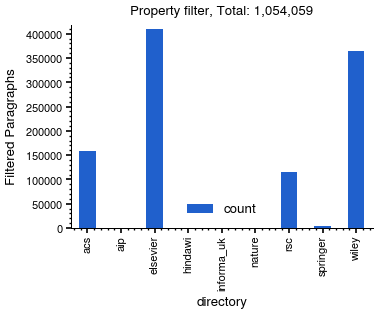

,directory,count
0,acs,159058
1,aip,4
2,elsevier,410527
3,hindawi,8
4,informa_uk,33
5,nature,16
6,rsc,115303
7,springer,3712
8,wiley,365398


In [16]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'property_%'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property filter, Total: {total:,}')
plt.savefig('notebooks/property_filtered_para_per_directory.png', dpi=600)
plt.show()
df

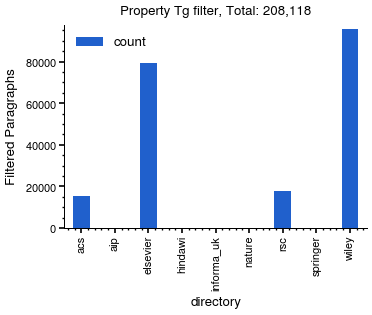

,directory,count
0,acs,15156
1,aip,2
2,elsevier,79207
3,hindawi,2
4,informa_uk,15
5,nature,10
6,rsc,17842
7,springer,53
8,wiley,95831


In [17]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'property_tg'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property Tg filter, Total: {total:,}')
plt.savefig('notebooks/tg_filtered_para_per_directory.png', dpi=600)
plt.show()
df

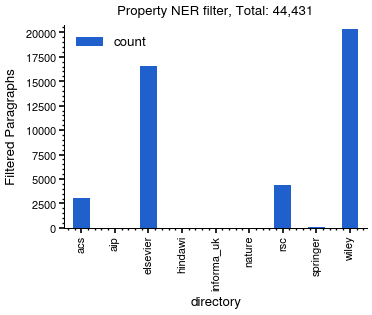

,directory,count
0,acs,3038
1,aip,2
2,elsevier,16519
3,hindawi,2
4,informa_uk,13
5,nature,10
6,rsc,4427
7,springer,51
8,wiley,20369


In [18]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'ner_tg'
    AND fp.filter_name != 'ner_filter'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property NER filter, Total: {total:,}')
plt.savefig('notebooks/property_ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

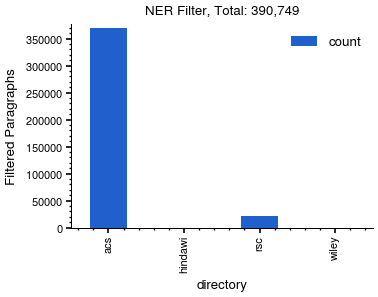

,directory,count
0,acs,369040
1,hindawi,3
2,rsc,21704
3,wiley,2


In [19]:
df = execute("""
    -- general ner filter
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'ner_filter'
    GROUP BY pt.directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = f'NER Filter, Total: {total:,}')
plt.savefig('notebooks/ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

### Extracted Data

In [20]:
# Materials extracted.
execute("select count(*) from extracted_materials")

,count
0,656800


In [21]:
# Properties extracted.
execute("select count(*) from extracted_properties")

,count
0,1345764


In [22]:
def extract_properties(property : str):
    df = execute("""
        SELECT pt.doi, em.entity_name AS material, ep.numeric_value, ep.unit
        FROM extracted_properties ep
        -- get material name and class
        JOIN extracted_materials em ON em.id = ep.material_id
        -- get doi
        JOIN paper_texts pt ON pt.id = em.para_id
        -- filter with property coreferents
        WHERE ep.entity_name IN (
            SELECT UNNEST(pm.other_names) FROM property_metadata pm
            WHERE pm.name = :prop_name
        )
        -- value should be within range
        AND ep.numeric_value >= (
            SELECT lower_limit FROM property_metadata
            WHERE name = :prop_name
        )
        AND ep.numeric_value <= (
            SELECT upper_limit FROM property_metadata
            WHERE name = :prop_name
        )
        -- select only polymers
        AND em.material_class LIKE 'POLYMER%';
    """, prop_name=property)
    return df

In [23]:
def unit_counts(df):
    return df.groupby('unit').nunique().numeric_value.sort_values(ascending=False)

In [24]:
def plot_histogram(df, name):
    # Most common unit
    unit = df.groupby('unit').nunique().numeric_value.sort_values(ascending=False).index[0]
    avg = df.numeric_value.mean()
    stdev = df.numeric_value.std()

    fig, ax = plt.subplots()
    df.hist('numeric_value', bins=20, label=f'Total: {df.shape[0]:,}', ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/hist.{name.replace("/", "_")}.png', dpi=300)
    plt.show()

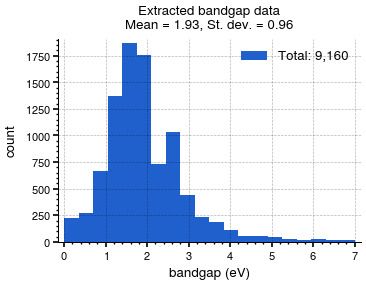

,doi,material,numeric_value,unit
0,10.1021/jp201019c,poly­(styrene-ran -TMS-indanolyl­styrene),2.65,eV
1,10.1021/jp201019c,PEG1000)_{3},2.65,eV
2,10.1021/jp201019c,PEG750)_{3,2.65,eV
3,10.1021/jp201019c,BCP P6,2.65,eV
4,10.1021/jp201019c,polyvinyl carbazole,2.65,eV
...,...,...,...,...
9155,10.1021/ja1085996,poly(ethylene terephthalate),1.20,∼ eV
9156,10.1021/ja1085996,"poly(4,8-dihexyl-2,6-bis(3-hexylthiophen-2-yl)...",1.20,∼ eV
9157,10.1021/ja1085996,BDT,1.20,∼ eV
9158,10.1021/ja1085996,PDQT,1.20,∼ eV


In [25]:
df = extract_properties('bandgap')
plot_histogram(df, 'bandgap')
df

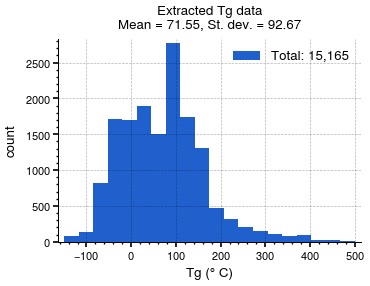

,doi,material,numeric_value,unit
0,10.1021/ma0201025,polystyrene,68.0,° C
1,10.1039/c7py01985h,poly (ECH-MeIm^{+}Cl^{-}),92.0,°C
2,10.1039/c7py01985h,poly (ECH-MeIm^{+}TFSI^{-}),-12.0,°C
3,10.1039/c7py01985h,poly (ECH-MeIm^{+}BF_{4}^{-}),67.0,°C
4,10.1039/c7cp00785j,PLGA,45.0,°C
...,...,...,...,...
15160,10.1021/acsapm.0c01335,CCM-0-A,10.5,° C
15161,10.1021/acsapm.0c01335,DBEDT,10.5,° C
15162,10.1021/acsapm.0c01335,ESOA-DBEDT,10.5,° C
15163,10.1021/acsapm.0c01335,ESOA-HDT,10.5,° C


In [26]:
df = extract_properties('glass transition temperature')
plot_histogram(df, 'Tg')
df

In [29]:
# Make histograms for all properties.
props = execute("select * from property_metadata")
print(", ".join(props.name))
# for prop in props.name:
#     df = extract_properties(prop)
#     if df is not None:
#         plot_histogram(df, prop)

gravimetric energy density, gravimetric power density, specific capacitance, current density, areal current density, areal power density, ionic conductivity, electrical conductivity, methanol permeability, fill factor, power conversion efficiency, open circuit voltage, short circuit current, tensile strength, youngs modulus, thermal conductivity, thermal decomposition temperature, crystallization temperature, glass transition temperature, melting temperature, polydispersity index, number average molecular weight, elongation at break, limiting oxygen index, coulombic efficiency, dielectric constant, molecular weight, crystallinity, CO_{2} permeability, O_{2} permeability, H_{2} permeability, air permeability, CO_{2}/N_{2} selectivity, CO_{2}/CH_{4} selectivity, O_{2}/N_{2} selectivity, H_{2}/CO_{2} selectivity, adsorption capacity, flexural strength, porosity, water contact angle, zeta potential, lower critical solution temperature, upper critical solution temperature, detection limit, 

In [31]:
postgres.disconnect()